# How to use pysigproc to generate candidates

In [1]:
from candidate import Candidate
import numpy as np
from scipy.signal import detrend
import h5plotter
import pylab as plt
import logging
logger = logging.getLogger()
logger = logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(threadName)s - %(levelname)s -'
                                                        ' %(message)s')

Here is the heimdall output from our file:

S/N, Sample, Time, Width, DM trial, DM, Members, Start Sample, End Sample

88.6941	6305	0.826	1	34	56.838	295	6304	6308

First, we make the candiate object

In [27]:
# creating the candidate object with a certain dm, label, snr, tcand and width
cand = Candidate(fp=f'Stokes_512I.dat.fil', dm=56.838, label=1, snr=88.694, tcand=0.826, width=2**1)

In [28]:
# Get data, this will take data from the filterbank file, and can be accessed from cand.data:
cand.get_chunk()
print(cand.data, cand.data.shape,cand.dtype)

[[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [1 1 0 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]] (338, 512) <class 'numpy.uint8'>


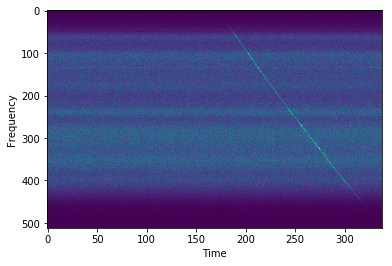

In [29]:
# here is our dispersed pulse
plt.imshow(cand.data.T,aspect='auto',interpolation=None)
plt.ylabel('Frequency')
plt.xlabel('Time')
plt.show()

In [30]:
# Now let's make the DM Time plot. This may take a while. 
cand.dmtime()

100%|██████████| 256/256 [00:05<00:00, 48.00it/s]


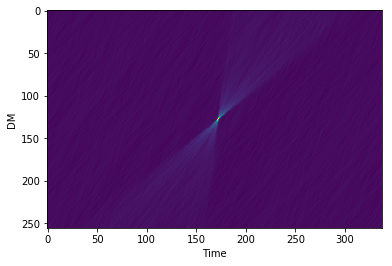

In [31]:
# the DM time plot can be accessed using cand.dmt. Let's have a look: 
plt.imshow(cand.dmt, aspect='auto',interpolation=None)
plt.ylabel('DM')
plt.xlabel('Time')
plt.show()

In [32]:
# Now let's Dedisperse it!
cand.dedisperse()

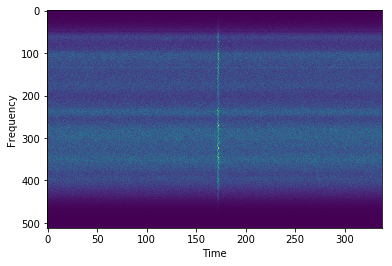

In [33]:
# The dedispersed pulse can be obtained using cand.dedispersed
plt.imshow(cand.dedispersed.T,aspect='auto',interpolation=None)
plt.ylabel('Frequency')
plt.xlabel('Time')
plt.show()

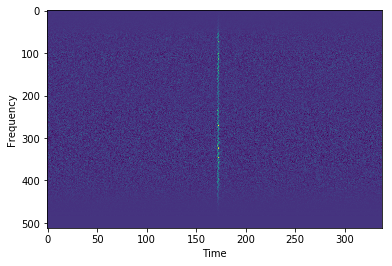

In [34]:
# Detrending can be used to remove bandpass variations
plt.imshow(detrend(cand.dedispersed.T),aspect='auto',interpolation=None)
plt.ylabel('Frequency')
plt.xlabel('Time')
plt.show()

In [35]:
# Optimise dm could be used to obtain accurate value of dm, and snr at that dm (under testing)
cand.optimize_dm()
print(f'Heimdall reported dm: {cand.dm}, Optimised DM: {cand.dm_opt}')
print(f'Heimdall reported snr: {cand.snr}, SNR at Opt. DM: {cand.snr_opt}')

Heimdall reported dm: 56.838, Optimised DM: 56.838
Heimdall reported snr: 88.694, SNR at Opt. DM: 81.65526303534627


In [36]:
# for now, let's enter some random values for dm_opt and snr_opt
cand.dm_opt = -1
cand.snr_opt = -1

In [37]:
# Name of the candidate
cand.id

'cand_tstart_56932.000000000000_tcand_0.8260000_dm_56.83800_snr_88.69400'

In [38]:
# Now let's save our candidate in an h5
fout=cand.save_h5()
print(fout) 

cand_tstart_56932.000000000000_tcand_0.8260000_dm_56.83800_snr_88.69400.h5


<Figure size 432x288 with 0 Axes>

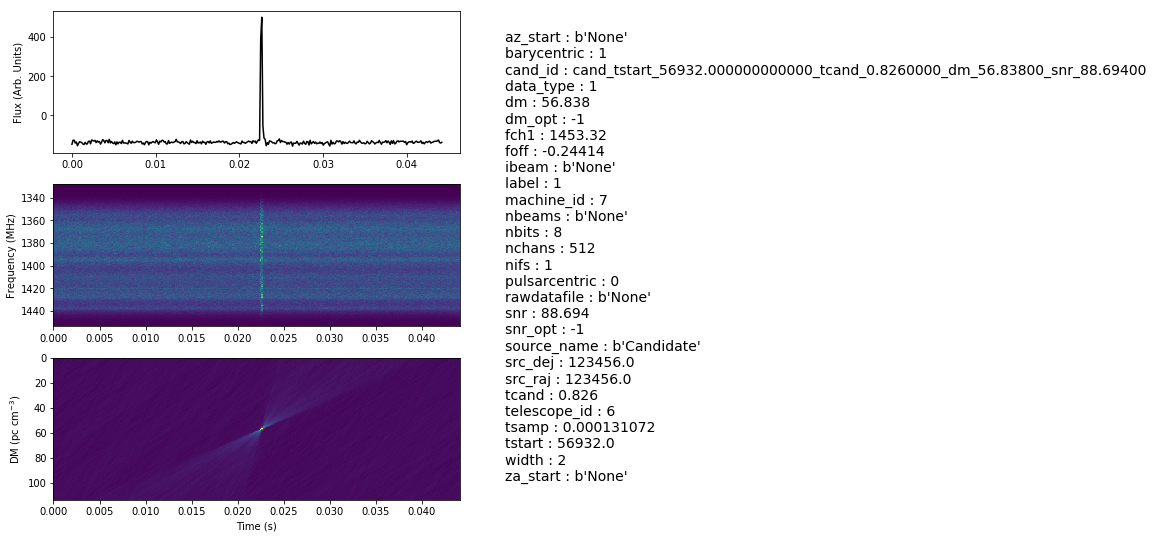

In [39]:
# We will use h5plotter to plot the candidate h5 we just generated
h5plotter.plot_h5(fout, show=True, detrend=False, save=False)

# Reshaping Freq-time and DM-time arrays

In [40]:
dedispersed_bkup = cand.dedispersed
dmt_bkup = cand.dmt

In [41]:
print(f'Shape of dedispersed (frequency-time) data: {dedispersed_bkup.T.shape}')
print(f'Shape of DM-time data: {dmt_bkup.shape}')

Shape of dedispersed (frequency-time) data: (512, 338)
Shape of DM-time data: (256, 338)


In [42]:
time_size = 256
freq_size = 256

# Using resize in skimage.transform for reshaping

In [43]:
#resize dedispersed Frequency-time array along time axis
cand.resize(key='ft', size=time_size, axis=0, anti_aliasing=True)

#resize dedispersed Frequency-time array along time axis
cand.resize(key='ft', size=freq_size, axis=1, anti_aliasing=True)
logging.info(f'Resized Frequency-Time data to fsize: {freq_size} and tsize: {time_size}')

print(f'Shape of dedispersed (frequency-time) data: {cand.dedispersed.T.shape}')

2019-02-21 04:22:57,780 - root - MainThread - INFO - Resized Frequency-Time data to fsize: 256 and tsize: 256


Shape of dedispersed (frequency-time) data: (256, 256)


In [44]:
#resize DM-time array along time axis
cand.resize(key='dmt', size = time_size, axis=1, anti_aliasing=True)
logging.info(f'Resized DM-Time to dmsize: 256 and tsize: {time_size}')
print(f'Shape of DM-time data: {cand.dmt.shape}')

2019-02-21 04:22:59,386 - root - MainThread - INFO - Resized DM-Time to dmsize: 256 and tsize: 256


Shape of DM-time data: (256, 256)


# Using decimate for reshaping

In [45]:
from candidate import crop

In [46]:
cand.dedispersed = dedispersed_bkup
cand.dmt = dmt_bkup

In [47]:
# Let's use pulse width to decide the decimate factor by which to collape the time axis
pulse_width = cand.width
if pulse_width == 1:
    time_decimate_factor = 1
else:
    time_decimate_factor = pulse_width // 2  

# Decimating time axis, and cropping to the final size
cand.decimate(key='ft', axis=0, pad=True, decimate_factor=time_decimate_factor, mode='median')
crop_start_sample_ft = cand.dedispersed.shape[0] // 2 - time_size // 2
cand.dedispersed = crop(cand.dedispersed, crop_start_sample_ft, time_size, 0)

# Decimating frequency axis
cand.decimate(key='ft', axis=1, pad=True, decimate_factor=cand.dedispersed.shape[1]//freq_size, mode='median')
logging.info(f'Decimated Frequency-Time data to fsize: {freq_size} and tsize: {time_size}')

print(f'Shape of dedispersed (frequency-time) data: {cand.dedispersed.T.shape}')

2019-02-21 04:22:59,924 - root - MainThread - INFO - Decimated Frequency-Time data to fsize: 256 and tsize: 256


Shape of dedispersed (frequency-time) data: (256, 256)


In [48]:
# Reshaping the DM-time using decimation
# Decimating time axis and croppig to the final required size 
cand.decimate(key='dmt', axis=1, pad=True, decimate_factor=time_decimate_factor, mode='median')
crop_start_sample_dmt = cand.dmt.shape[1] // 2 - time_size // 2
cand.dmt = crop(cand.dmt, crop_start_sample_dmt, time_size, 1)
logging.info(f'Decimated DM-Time to dmsize: 256 and tsize: {time_size}')
print(f'Shape of DM-time data: {cand.dmt.shape}')

2019-02-21 04:23:01,290 - root - MainThread - INFO - Decimated DM-Time to dmsize: 256 and tsize: 256


Shape of DM-time data: (256, 256)
